Dataset Shape: (32561, 15)

First 5 Rows:
    age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0          2174          

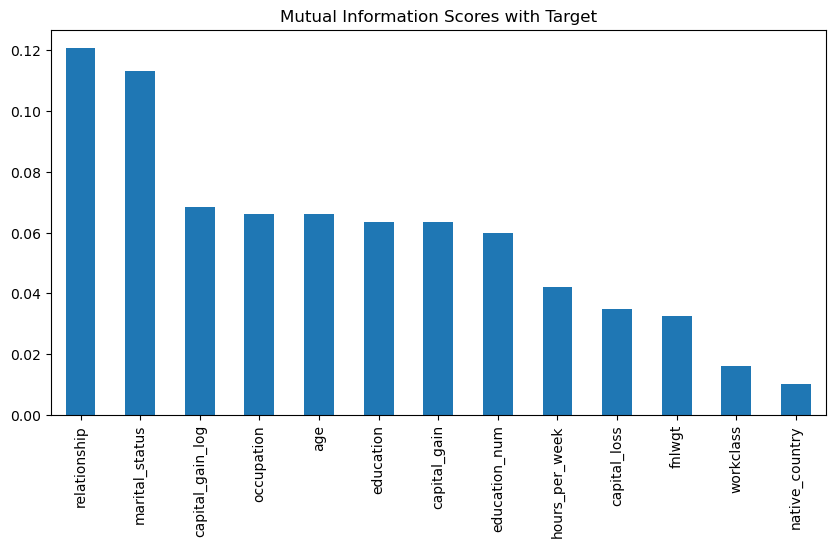

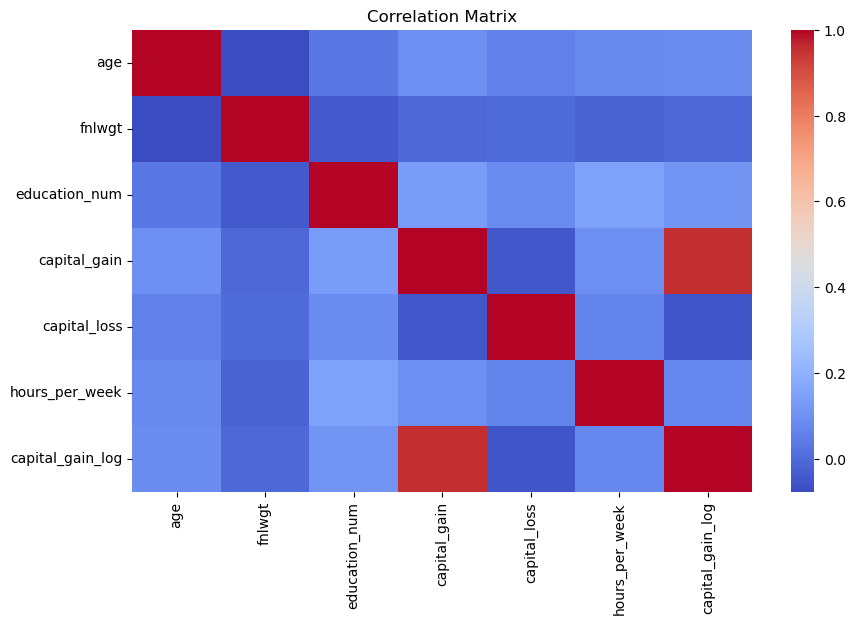

In [33]:
# -------------------------------
# 1. Import Required Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

# -------------------------------
# 2. Load Dataset
# -------------------------------
df = pd.read_csv(r"C:\Users\Sindu\Desktop\Assignment ExcelR\EDA2\EDA2\adult_with_headers.csv")

print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())

# -------------------------------
# 3. Handle Missing Values
# -------------------------------
num_features = df.select_dtypes(include=[np.number]).columns
cat_features = df.select_dtypes(include=["object"]).columns.drop("income")  # exclude target

imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

df[num_features] = imputer_num.fit_transform(df[num_features])
df[cat_features] = imputer_cat.fit_transform(df[cat_features])

print("\nMissing Values After Imputation:\n", df.isnull().sum())

# -------------------------------
# 4. Scaling
# -------------------------------
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

df_standard = df.copy()
df_minmax = df.copy()

df_standard[num_features] = scaler_standard.fit_transform(df[num_features])
df_minmax[num_features] = scaler_minmax.fit_transform(df[num_features])

# -------------------------------
# 5. Encoding
# -------------------------------
target = "income"
features = [col for col in df.columns if col != target]

low_cardinality = [col for col in features if df[col].nunique() <= 5]
high_cardinality = [col for col in features if df[col].nunique() > 5]

df_encoded = df.copy()

# One-Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=low_cardinality, drop_first=True)

# Label Encoding
le = LabelEncoder()
for col in high_cardinality:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Encode target separately
df_encoded[target] = LabelEncoder().fit_transform(df[target])   # <=50K → 0, >50K → 1

# -------------------------------
# 6. Feature Engineering
# -------------------------------
df_fe = df_encoded.copy()

# Age buckets
df_fe["age_bucket"] = pd.cut(df["age"], bins=[0, 25, 40, 60, 100], 
                             labels=["Young", "Adult", "Middle-aged", "Senior"])

# Work intensity buckets
df_fe["work_intensity"] = pd.cut(df["hours_per_week"], bins=[0, 20, 40, 60, 100], 
                                 labels=["Part-time", "Full-time", "Overtime", "Extreme"])

# Log transform on skewed feature
df_fe["capital_gain_log"] = np.log1p(df["capital_gain"])

print("\nFeature Engineering Done. Sample:\n", 
      df_fe[["age","hours_per_week","capital_gain","capital_gain_log","age_bucket","work_intensity"]].head())

# -------------------------------
# 7. Feature Selection
# -------------------------------
# --- Outlier Detection
iso = IsolationForest(contamination=0.02, random_state=42)
outliers = iso.fit_predict(df_fe.select_dtypes(include=[np.number]))

df_no_outliers = df_fe[outliers == 1]

print("\nOriginal Shape:", df_fe.shape)
print("After Removing Outliers:", df_no_outliers.shape)

# --- Mutual Information
X = df_no_outliers.drop(columns=[target])
y = df_no_outliers[target]

mi_scores = mutual_info_classif(X.select_dtypes(include=[np.number]), y, discrete_features='auto')
mi_scores = pd.Series(mi_scores, index=X.select_dtypes(include=[np.number]).columns)
mi_scores = mi_scores.sort_values(ascending=False)

print("\nMutual Information Scores:\n", mi_scores)

plt.figure(figsize=(10,5))
mi_scores.plot(kind="bar")
plt.title("Mutual Information Scores with Target")
plt.show()

# --- Correlation Matrix 
plt.figure(figsize=(10,6))

numeric_df = df_no_outliers.select_dtypes(include=['int64', 'float64'])  # keep only numeric features
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)

plt.title("Correlation Matrix")
plt.show()
